# Model Inputs

### Packages

In [1]:
# General
import pandas as pd
import numpy as np
import pandas as pd
import os
DATA_DIR = "~/Desktop/code/data/"

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
import umap
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Classfication
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Visualization
import plotly.express as px
import plotly.graph_objects as go

### Dataset

In [2]:
# Loading output dataframe from data.ipynb
df = pd.read_csv(os.path.join(DATA_DIR, "model", "ml_input.csv"), low_memory=False)

# Filter non-specific ec numbers (e.g., 1.1.1,-)
filter = df["ec"].str.contains("-")
df = df[~filter]

# Format for machine learning
df = df[["taxon_id", "media_id", "ec"]].value_counts().reset_index()
df = df.pivot(index=["taxon_id", "media_id"], columns="ec", values="count")
df = df.fillna(0.0).reset_index()

# Filtering into training and test sets (database set vs. MAGs)
bins = df["media_id"].str.contains("unknown")
df_train = df[~bins]
df_test = df[bins]

### Split dataset

In [3]:
# Split the datasets into training and test sets
TARGET = "media_id" # target label
RANDOM_SEED = 47 # seed for random_state

# Test case with MAGs
X_train = df_train.drop(["taxon_id", "media_id"], axis=1)
y_train = df_train[TARGET] 
X_test = df_test.drop(["taxon_id", "media_id"], axis=1)
y_test = df_test[TARGET]

# Model

### Pipeline

In [4]:
# sklearn pipeline helps prevent data leakage; incorporate individual steps here
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(
        n_components=150,      
        random_state= RANDOM_SEED
        )),    
    ('umap', umap.UMAP(      
        metric="euclidean",
        n_epochs=500,
        random_state=RANDOM_SEED,
        n_jobs=1,
        n_components=40, 
        n_neighbors=62, 
        min_dist=0 
        )) 
]) 

### Fit and transform

In [5]:
# Fit and transform the pipeline on the training and test data
X_train_transformed = pipeline.fit_transform(X_train) # fit pipeline and transform training data
X_test_transformed = pipeline.transform(X_test) # transform test data

### Cluster

In [6]:
# Cluster
clusterer = KMeans(n_clusters=180, random_state=RANDOM_SEED)
cluster_labels = clusterer.fit_predict(X_train_transformed)
test_clusters = clusterer.predict(X_test_transformed)

### Metrics

In [7]:
# Initial dimensionality reduction performance (PCA)
pca = pipeline.named_steps['pca']
explained_variance = pca.explained_variance_ratio_
#print(f"PCA explained variance: {explained_variance}") # variance of each component
print(f"Total PCA explained variance: {explained_variance.sum()}")

# Further dimensionality reduction and clustering performance
silhouette_avg = silhouette_score(X_train_transformed, cluster_labels)
print(clusterer.labels_.max()+1, "KMeans training clusters")
print(f"Average Silhouette Score on KMeans clusters: {silhouette_avg}") # <0.25 implies poor clustering, 0.25<x<0.50 is fair, >50 is good

Total PCA explained variance: 0.8764737414669707
180 KMeans training clusters
Average Silhouette Score on KMeans clusters: 0.772323489189148


# Classifier

In [8]:
y2_train = cluster_labels
y2_test = test_clusters

### Random Forest

In [9]:
rfc = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

rfc.fit(X_train_transformed, y2_train)
print(rfc.predict(X_test_transformed))

[138 163 138 138 163 138  94 117 163 155  94 138  94  94 163   3 138 155
 123 117  94   3 117 117 117 117 163 155  94 117   3 156  67 156 138 117
  94 138 138 163  94 163 138 163 117 163 117  94 138 117 138   3 138 138
 155 138 141  94 163 138  94 138 155 155 117   3 117  94 155 138  94 138
  94 117  94 138 138  94  94  94 117  94  94  94   3  94  94 138   3 153
 138   3  94 117 138  94 155 131 163  94   3 123 156 117 163  94 117 117
 117 163 163 138 117 138  94  94 138 163 155 163 163   3 163 138 138 138
 138  94 123  94 163 163 138 138   3   3 163 117 117 138 131  94 117 156
 138  47 163 138   3 163  94 163 117 138 163 138   3 138 117 117 138 138
 138 155 141   3  94   3 163 163   3 163 123 163 138  94  47 138  94  58
 138 163 163 117 117  94  94 117 138  94 117 163   3 138   3 163  94   3
 138 123  94 163 123 117   3 155  94 138 117 117 131  94   3 117 163  94
 163 123 163   3 163  94   3   3   3   3 163   3 117 155  58   3  94   3
 117 138   3 117   3 123 138 163  94 117  94  94 12

In [10]:
report = classification_report(
    y_true=y2_test,
    y_pred=rfc.predict(X_test_transformed),
    zero_division=0.0 # Default: set to "warn", or float {0.0, 1.0}
)

roc_score = metrics.roc_auc_score(
    y_true=y2_test,
    y_score=rfc.predict_proba(X_test_transformed),
    labels=np.unique(y2_train),
    average="weighted",
    multi_class="ovo"
)

print(report)
print("RF ROC AUC score:", roc_score)

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        32
          47       1.00      1.00      1.00         2
          58       0.50      1.00      0.67         1
          67       1.00      1.00      1.00         1
          94       0.76      0.95      0.84        39
         117       0.97      0.70      0.82        54
         123       1.00      1.00      1.00         9
         131       1.00      1.00      1.00         3
         138       0.92      1.00      0.96        47
         141       0.00      0.00      0.00         0
         153       1.00      0.33      0.50         3
         155       1.00      1.00      1.00        12
         156       1.00      1.00      1.00         4
         163       0.93      0.93      0.93        40

    accuracy                           0.91       247
   macro avg       0.86      0.85      0.84       247
weighted avg       0.93      0.91      0.91       247

RF ROC AUC score: 0.99671

### Nearest Neighbors

In [11]:
knc= KNeighborsClassifier(n_neighbors=5)
knc.fit(X_train_transformed, cluster_labels)
distances, indices = knc.kneighbors(X_test_transformed)

print(knc.predict(X_test_transformed))

[138 163 138 138 163 117  94 117 163 155  94 138  94  94 163   3 138 155
 123 117  94   3 117 117 117 117 163 155  94 117   3 156  67 153 138 117
  94 138 138 163  94 163 138 163 117 163 117 117 138 117 138   3 138 138
 155 138 141  94 163 138  94 138 155 155 117   3 117 117 155 138 117 138
  94 117  94 138 138  94  94 117 117  94  94  94   3  94  94 138   3 153
 138   3 117 117 138  94 155 131 163  94   3 123 156 117 163  94 117 117
  94 163 117 138 117 138  94 117 138 163 117 163 163   3 163 138 138 138
 138 117 123  94 163 163 138 138   3   3 163 117 163 138 131  94 117 156
 138  47 163 138   3 117  94 163 117 138 163 138   3 138 117 117 138 138
 138 155 111   3  94   3 163 163   3 163 123 163 138  94  47 138  94  94
 138 163 163 117 117  94  94 117 138  94 117 163   3 138   3 163  94   3
 138 123  94 163 123 117   3 155  94 138 117 117 131 117   3 117 163  94
 163 123 163   3 163  94   3   3   3   3 163   3 117 155  58   3  94   3
 117 138   3 117   3 123 138 163 117 117 117  94 12

In [12]:
report = classification_report(
    y_true=y2_test,
    y_pred=knc.predict(X_test_transformed),
    zero_division=0.0 # Default: set to "warn", or float {0.0, 1.0}
)

roc_score = metrics.roc_auc_score(
    y_true=y2_test,
    y_score=knc.predict_proba(X_test_transformed),
    labels=np.unique(y2_train),
    average="weighted",
    multi_class="ovo"
)

print(report)
print("KNN ROC AUC score:", roc_score)

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        32
          47       1.00      1.00      1.00         2
          58       1.00      1.00      1.00         1
          67       1.00      1.00      1.00         1
          94       0.93      0.97      0.95        39
         111       0.00      0.00      0.00         0
         117       0.96      0.91      0.93        54
         123       1.00      1.00      1.00         9
         131       1.00      1.00      1.00         3
         138       0.94      1.00      0.97        47
         141       0.00      0.00      0.00         0
         153       0.50      0.33      0.40         3
         155       1.00      0.92      0.96        12
         156       1.00      0.75      0.86         4
         163       0.95      0.93      0.94        40

    accuracy                           0.95       247
   macro avg       0.82      0.79      0.80       247
weighted avg       0.95   

# Outputs

### Train, clustering labels

In [13]:
# Training data
train_df = pd.DataFrame(X_train_transformed, columns=[f"Component {i+1}" for i in range(X_train_transformed.shape[1])])
train_df['Set'] = 'Training'
train_df['Target'] = y_train
train_df['KMeans Cluster'] = cluster_labels
train_df['taxon_id'] = df_train["taxon_id"]

# Media cluster labels
media_clusters = pd.read_csv(os.path.join(DATA_DIR, "model", "media-clusters.csv"))
media_clusters = media_clusters[["media_id", "Cluster"]]
media_clusters = media_clusters.rename(columns={"media_id": "Target", "Cluster": "Media Cluster"})
target_label_mapping = dict(zip(media_clusters['Target'], media_clusters['Media Cluster']))
train_df['Media Cluster'] = train_df['Target'].map(target_label_mapping)

train_df.to_csv(os.path.join(DATA_DIR, "model", "train-output.csv"), index=False)
train_df.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Component 36,Component 37,Component 38,Component 39,Component 40,Set,Target,KMeans Cluster,taxon_id,Media Cluster
0,8.877258,5.368573,5.976608,5.567410,5.752917,4.890731,5.484498,5.908564,4.930583,5.352659,...,6.869729,4.994915,5.778642,3.910152,3.630782,Training,J346,112,100.0,NaN
1,9.131594,5.638107,5.949810,5.132954,4.882958,4.661012,5.534887,6.839547,4.804379,2.488934,...,4.965437,4.965490,5.094551,5.412997,5.210567,Training,J386,164,100.0,NaN
2,8.647167,5.515614,4.541187,4.840522,4.230924,4.675780,4.592118,3.662642,6.307117,8.584105,...,9.143206,4.835721,7.085607,3.096110,5.055593,Training,J233,3,100225.0,NaN
3,8.713597,5.501556,5.008151,5.610324,5.525953,4.904368,5.518972,4.571458,5.482652,7.380622,...,8.304418,5.090847,6.794505,2.982144,3.715566,Training,J22,119,1002526.0,42.0
4,9.308442,5.575479,4.788660,4.720118,4.320899,4.483849,4.655216,4.801590,6.320374,6.760714,...,4.880169,4.442428,7.164841,4.876586,5.876074,Training,1a,170,1004166.0,46.0


### Test, classifier labels

In [14]:
# Test data
test_df = pd.DataFrame(X_test_transformed, columns=[f"Component {i+1}" for i in range(X_test_transformed.shape[1])])
test_df['Set'] = 'Test'
test_df['Target'] = list(df_test['media_id'])
test_df['KMeans Cluster'] = test_clusters
test_df['taxon_id'] = list(df_test['taxon_id'])

# Add classifier labels 
test_df["KNN Classify"] = knc.predict(X_test_transformed)
test_df["RF Classify"] = rfc.predict(X_test_transformed)

test_df.to_csv(os.path.join(DATA_DIR, "model", "test-output.csv"), index=False)
test_df.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Component 37,Component 38,Component 39,Component 40,Set,Target,KMeans Cluster,taxon_id,KNN Classify,RF Classify
0,9.427101,5.556786,5.026694,4.718250,4.642046,4.580091,4.598486,4.929774,5.921600,6.780723,...,4.342175,6.616252,4.765223,5.496040,Test,unknown,138,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138
1,9.438310,5.577195,4.848787,4.642054,4.625227,4.483598,4.409244,4.932186,5.987401,6.837227,...,4.543643,6.369204,4.772368,5.501478,Test,unknown,163,KBase_derived_Bin.001.fastaBA_S_extracted_bins...,163,163
2,9.447886,5.541127,5.050786,4.717380,4.655841,4.581066,4.613263,4.935236,5.921442,6.821482,...,4.308320,6.693200,4.771678,5.495061,Test,unknown,138,KBase_derived_Bin.001.fastaCF_F_extracted_bins...,138,138
3,9.474887,5.521941,5.061490,4.708226,4.687949,4.567853,4.590333,4.946699,5.907719,6.889503,...,4.317766,6.713403,4.738154,5.454133,Test,unknown,138,KBase_derived_Bin.001.fastaCG_S_extracted_bins...,138,138
4,9.431704,5.578809,4.869885,4.653165,4.616782,4.497761,4.442394,4.926748,5.984292,6.815331,...,4.511312,6.415678,4.784357,5.515740,Test,unknown,163,KBase_derived_Bin.001.fastaFE_F_extracted_bins...,163,163


### ID nearest neighbors

In [15]:
# Add nearest neighbor indices to the test dataframe
knn_df = test_df.copy()
knn_df = knn_df.rename(columns={"KMeans Cluster": "Test Cluster"})
neighbors = pd.DataFrame(indices) # Indices of nearest neighbors from the training set
knn_df['indices'] = neighbors[neighbors.columns[0:]].apply(lambda x: ';'.join(x.dropna().astype(str)), axis=1)
knn_df["indices"] = knn_df["indices"].str.split(';')
knn_df = knn_df.explode("indices")

# Add original indices as a column for the train dataframe
train_index = train_df.copy()
train_index = train_index.rename(columns={"KMeans Cluster": "Train Cluster"})
train_index["indices"] = df_train.index
train_index["indices"] = train_index["indices"].astype(str)

# Merge to label nearest neighbors
left = knn_df.copy()
right = train_index[["indices", "Target", "taxon_id", "Media Cluster"]]
right = right.rename(columns={"Target": "neighbor_media_id", "taxon_id": "neighbor_taxon_id", "Cluster": "neighbor_cluster"})
merged = pd.merge(left, right, on="indices", how="left")

merged.to_csv(os.path.join(DATA_DIR, "model", "ml-model-output.csv"), index=False)
merged

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Set,Target,Test Cluster,taxon_id,KNN Classify,RF Classify,indices,neighbor_media_id,neighbor_taxon_id,Media Cluster
0,9.427101,5.556786,5.026694,4.71825,4.642046,4.580091,4.598486,4.929774,5.921600,6.780723,...,Test,unknown,138,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,6167,J654,438.0,NaN
1,9.427101,5.556786,5.026694,4.71825,4.642046,4.580091,4.598486,4.929774,5.921600,6.780723,...,Test,unknown,138,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,5109,J92,33018.0,NaN
2,9.427101,5.556786,5.026694,4.71825,4.642046,4.580091,4.598486,4.929774,5.921600,6.780723,...,Test,unknown,138,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,7399,J960,65958.0,NaN
3,9.427101,5.556786,5.026694,4.71825,4.642046,4.580091,4.598486,4.929774,5.921600,6.780723,...,Test,unknown,138,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,1513,87a,1520.0,40.0
4,9.427101,5.556786,5.026694,4.71825,4.642046,4.580091,4.598486,4.929774,5.921600,6.780723,...,Test,unknown,138,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,7126,J27,589382.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,9.318041,5.616743,4.922110,4.72845,4.592251,4.598436,4.516470,4.602196,5.800026,6.956274,...,Test,unknown,123,KBase_derived_Bin.039.fastaLS_S_extracted_bins...,123,123,4847,J84,2981779.0,NaN
1231,9.318041,5.616743,4.922110,4.72845,4.592251,4.598436,4.516470,4.602196,5.800026,6.956274,...,Test,unknown,123,KBase_derived_Bin.039.fastaLS_S_extracted_bins...,123,123,4846,J14,2981779.0,2.0
1232,9.318041,5.616743,4.922110,4.72845,4.592251,4.598436,4.516470,4.602196,5.800026,6.956274,...,Test,unknown,123,KBase_derived_Bin.039.fastaLS_S_extracted_bins...,123,123,4845,J13,2981779.0,131.0
1233,9.318041,5.616743,4.922110,4.72845,4.592251,4.598436,4.516470,4.602196,5.800026,6.956274,...,Test,unknown,123,KBase_derived_Bin.039.fastaLS_S_extracted_bins...,123,123,7311,1203a,646.0,143.0


# Visualization

### Feature importance

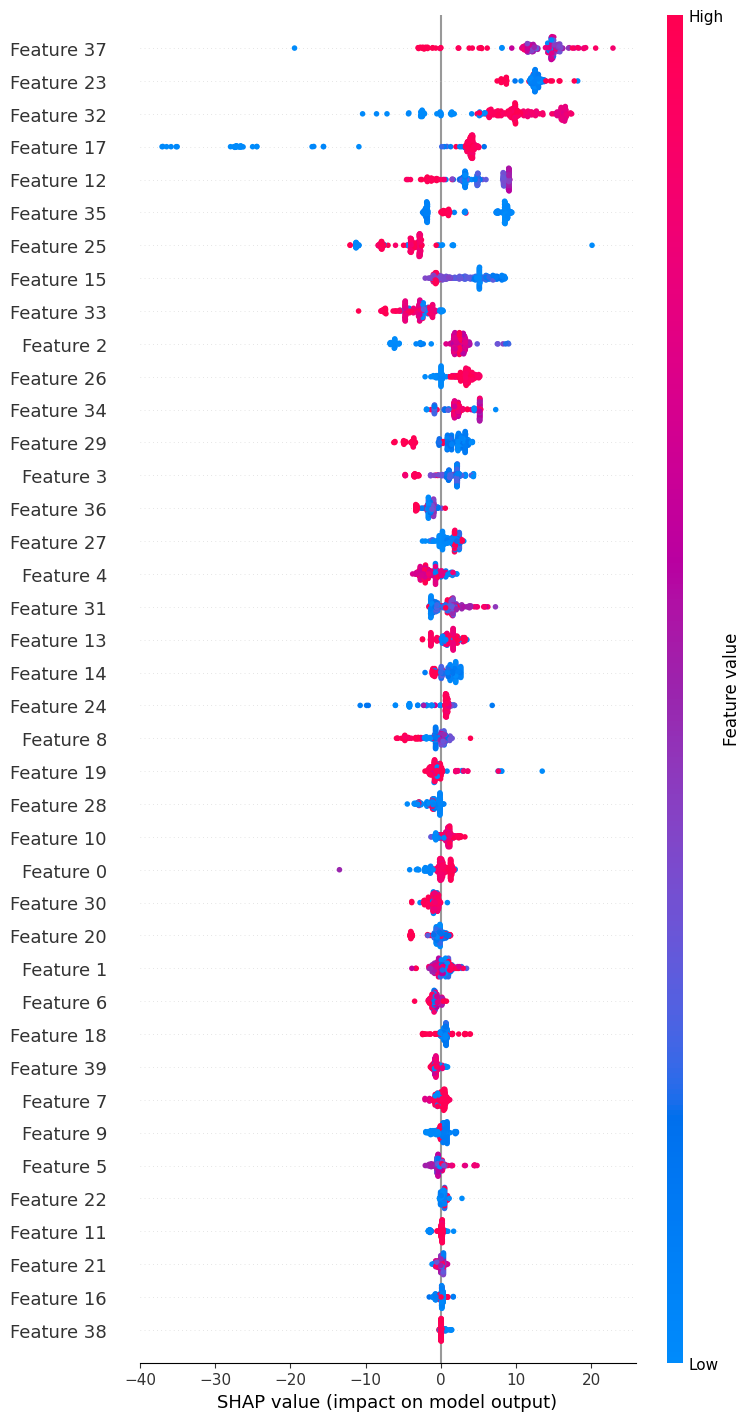

In [26]:
import xgboost
import shap

XG_train = X_train_transformed
yG_train = cluster_labels
XG_test = X_test_transformed
yG_test = test_clusters

# train an XGBoost model
model1 = xgboost.XGBRegressor().fit(XG_train, yG_train)
#model2 = xgboost.XGBRegressor().fit(XG_test, yG_test)

# explain the model's predictions using SHAP
explainer = shap.Explainer(model1)
shap_values = explainer(XG_test)

shap.plots.initjs()
shap.plots.beeswarm(shap_values, max_display=40)

In [17]:
#shap.plots.waterfall(shap_values[0])
#shap.plots.force(shap_values[:500])

### n dimensions

In [82]:
# Highest-importance features
dim1 = "Component 38" 
dim2 = "Component 24"

In [83]:
fig = px.scatter(
    data_frame = train_df,
    x = dim1,
    y = dim2, # Change components to visualize each of the 30 dimensions
    color = "Media Cluster",
    hover_data = ["taxon_id", "Target", "KMeans Cluster"],
    opacity = 0.3
) 

# Add the test points as a scatter trace
fig.add_trace(
    go.Scatter(
        x=test_df[dim1],  # x coordinates
        y=test_df[dim2],  # y coordinates
        mode='markers',
        marker=dict(
            color='black',  
            size=5,  
            opacity=1.0 
        ),
        text=test_df["taxon_id"]  # marker hover text
    )
)

# Opacity slider
steps = []
for i in range(11):  # 0 to 1 in steps of 0.1
    step = dict(
        method="restyle",
        args=[{"marker.opacity": [i/20]}, [0]],  # Adjust opacity of the first trace only
        label=str(i/20)
    )
    steps.append(step)
sliders = [dict(
    active=3,  # initial value corresponding to opacity=0.3
    currentvalue={"prefix": "Opacity: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_coloraxes(showscale=False)
fig.update_layout(
    sliders=sliders,
    title="KMeans Clustering",
    template="plotly_white",
    showlegend=False
)

fig.show()

### 2 dimensions

#### 2D Pipeline

In [19]:
# copy of model pipeline reduced to two dimensions, ***LEADS TO DISCONNECT IN DIMENSIONALITY REDUCTION STEPS***
visualization = Pipeline([
    ('scaler', StandardScaler()),   
    ('pca', PCA(n_components=150)),   
    ('umap', umap.UMAP(              
        metric="euclidean",
        n_epochs=200, 
        random_state=RANDOM_SEED,
        n_jobs=1,
        n_components=2, # reduced for visualization
        n_neighbors=62, 
        min_dist=0 
        )) 
]) 

# Fit and transform the pipeline on the training and test data
X_train_embedding = visualization.fit_transform(X_train) # fit pipeline and transform training data
X_test_embedding = visualization.transform(X_test) # transform test data

# Cluster
vclusterer = KMeans(n_clusters=179, random_state=RANDOM_SEED)
vcluster_labels = vclusterer.fit_predict(X_train_embedding)
vtest_clusters = vclusterer.predict(X_test_embedding)

# Metrics to compare to 30 dimensions
vpca = visualization.named_steps['pca']
vexplained_variance = vpca.explained_variance_ratio_
vsilhouette_avg = silhouette_score(X_train_embedding, vcluster_labels)
print(f"Total PCA explained variance: {vexplained_variance.sum()}")
print(vclusterer.labels_.max()+1, "KMeans training clusters")
print(f"Average Silhouette Score on KMeans clusters: {vsilhouette_avg}") # <0.25 implies poor clustering, 0.25<x<0.50 is fair, >50 is good

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\umap\spectral.py:550: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!



Total PCA explained variance: 0.8764128740770921
179 KMeans training clusters
Average Silhouette Score on KMeans clusters: 0.7951236963272095


#### Visualization

In [20]:
# Training data
train_2d = pd.DataFrame(X_train_embedding, columns=[f"Component {i+1}" for i in range(X_train_embedding.shape[1])])
train_2d['Set'] = 'Training'
train_2d['Target'] = y_train
train_2d['KMeans Cluster'] = cluster_labels
train_2d['taxon_id'] = df_train["taxon_id"]

# Media cluster labels
media_clusters = pd.read_csv(os.path.join(DATA_DIR, "model", "media-clusters.csv"))
media_clusters = media_clusters[["media_id", "Cluster"]]
media_clusters = media_clusters.rename(columns={"media_id": "Target", "Cluster": "Media Cluster"})
target_label_mapping = dict(zip(media_clusters['Target'], media_clusters['Media Cluster']))
train_2d['Media Cluster'] = train_2d['Target'].map(target_label_mapping)

# Test data
test_2d = pd.DataFrame(X_test_embedding, columns=[f"Component {i+1}" for i in range(X_test_embedding.shape[1])])
test_2d['Set'] = 'Test'
test_2d['Target'] = list(df_test['media_id'])
test_2d['KMeans Cluster'] = test_clusters
test_2d['taxon_id'] = list(df_test['taxon_id'])

In [25]:
# Plot the training points
fig = px.scatter(
    data_frame = train_2d,
    x = "Component 1",
    y = "Component 2", # Change components to visualize each of the 30 dimensions
    color = "Media Cluster",
    hover_data = ["taxon_id", "Target", "KMeans Cluster"],
    opacity = 0.3
) 

# Add the test points as a scatter trace
fig.add_trace(
    go.Scatter(
        x=test_2d["Component 1"],  # x coordinates
        y=test_2d["Component 2"],  # y coordinates
        mode='markers',
        marker=dict(
            color='black',  
            size=5,  
            opacity=1.0 
        ),
        text=test_2d["taxon_id"]  # marker hover text
    )
)

# Opacity slider
steps = []
for i in range(11):  # 0 to 1 in steps of 0.1
    step = dict(
        method="restyle",
        args=[{"marker.opacity": [i/20]}, [0]],  # Adjust opacity of the first trace only
        label=str(i/20)
    )
    steps.append(step)
sliders = [dict(
    active=3,  # initial value corresponding to opacity=0.3
    currentvalue={"prefix": "Opacity: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_coloraxes(showscale=False)
fig.update_layout(
    sliders=sliders,
    title="2 Dimensions",
    template="plotly_white",
    showlegend=False
)

fig.show()